In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Load your CSV file
df = pd.read_csv('Songs.csv')

# Preprocess the lyrics
all_lyrics = ' '.join(df['Lyrics'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts([all_lyrics])
total_words = len(tokenizer.word_index) + 1

# Convert the lyrics to sequences of tokens
input_sequences = []
for line in df['Lyrics']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max(len(x) for x in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Predictors are every word except the last; target is the last word
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

# Define the RNN model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1569, 100)         1496500   
                                                                 
 bidirectional (Bidirection  (None, 1569, 300)         301200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               320800    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 14965)             3007965   
                                                                 
Total params: 5126465 (19.56 MB)
Trainable params: 5126465 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The goal of our model is to capture the intricacy of human language and the artistic expression found in music lyrics, utilizing a dataset of existing songs.

The process begins with preprocessing. We load our lyrics dataset, which contains a variety of songs, and we aim to transform this text data into a structured format that our neural network can interpret. The preprocessing steps include tokenization, where we convert words into numerical indices, and sequence padding, ensuring uniform input size for feeding into our neural network. Also, since we are using title as the seed text to generate lyrics, we added a 'special token' to seperate the title and lyrics of raw data to aware the model which part is title or lyrics while training.

The architecture of our RNN is designed with the consideration of both performance and system limitations. It comprises several layers, each chosen for their role in the process of sequence learning:

An Embedding layer, which translates our tokenized indices into dense vectors of fixed size. Here, we chose a dimensionality of 100 to capture sufficient semantic information while balancing memory constraints.

Two Bidirectional LSTM layers. LSTMs are chosen for their ability to remember information over long sequences, which is crucial for generating coherent lyrics. The bidirectionality allows the network to access both past (backward) and future (forward) contexts at every point in the sequence, providing a richer understanding of the text. The first LSTM layer has 150 units, and the second one has 100 units. This decreasing unit strategy is a design choice to condense the information flow for the final prediction.

A Dense layer, with a number of neurons equal to the size of the vocabulary, which serves as the output layer. It uses a softmax activation function to generate a probability distribution over all possible next words in the sequence.

This architecture was summarized, showing a total of over 5 million parameters. Each parameter contributes to the learning capacity of the network, but also to the memory footprint. We have carefully chosen the size of the network to stay within the boundaries of 83.5GB of system RAM and 40GB of GPU RAM, ensuring that we maximize learning capability without exceeding our computational resources.

The model is compiled with the categorical crossentropy loss function and the Adam optimizer, a standard choice for classification problems like ours. This setup helps us effectively navigate the trade-off between computational efficiency and predictive performance.

In [3]:
# Fit the model
history=model.fit(predictors, label, epochs=20, verbose=1)

# Save the model for later use
model.save('lyrics_model.h5')



Epoch 1/20
11505/11505 [==============================] - 2544s 220ms/step - loss: 6.0379 - accuracy: 0.0850
Epoch 2/20
11505/11505 [==============================] - 2369s 206ms/step - loss: 5.4278 - accuracy: 0.1275
Epoch 3/20
11505/11505 [==============================] - 2363s 205ms/step - loss: 5.1175 - accuracy: 0.1504
Epoch 4/20
11505/11505 [==============================] - 2359s 205ms/step - loss: 4.8770 - accuracy: 0.1705
Epoch 5/20
11505/11505 [==============================] - 2358s 205ms/step - loss: 4.6783 - accuracy: 0.1899
Epoch 6/20
11505/11505 [==============================] - 2359s 205ms/step - loss: 4.5011 - accuracy: 0.2087
Epoch 7/20
11505/11505 [==============================] - 2356s 205ms/step - loss: 4.3328 - accuracy: 0.2281
Epoch 8/20
11505/11505 [==============================] - 2357s 205ms/step - loss: 4.1682 - accuracy: 0.2475
Epoch 9/20
11505/11505 [==============================] - 2356s 205ms/step - loss: 4.0113 - accuracy: 0.2672
Epoch 10/20
11505/1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Function to generate text

def generate_text(seed_text, next_words, model, max_sequence_len, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature to the predictions
        predictions = np.log(predictions + 1e-7) / temperature  # Smoothing and avoid log(0)
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)

        # Choose the next word with weighted probability
        next_word_index = np.random.choice(len(predictions), p=predictions)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == next_word_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate new lyrics
print(generate_text("Love", 200, model, max_sequence_len, temperature=1.05))

Love is been true and i'm still trying when i feel here at home and i know you're gone long nights but i think i have to laugh baby i know that you all have guns and she just wanna be alone i'm giving you to talk what we once want to wake all that one broke oh way out i need all my plans ooh i'd follow you in my head the things you could know how i know ow ow ow i'm on guard when i see you again when i see you again i'm not your rider when i'm so sad when it's so sorry well that's alright 'cause you make me feel so young i look inside to get down we've been on fire and then oy long we roll again we keep it all right my way for you you're alone just need to love you every time i can take my soul by lost when i felt the way you let my jumpsuit don't let me live in heaven moment 'cause i won't let go oh darling yes who's on your face that you gave from me and you from her it'll let you go


The generate_text function is the culmination of our efforts, where we harness the trained model to produce novel lyrics.

This function operates by taking a seed text as input, which is the title of song that prompts the model to begin the generation process. It then predicts the next word in the sequence, appends it to the seed text, and repeats this process for a specified number of iterations, which is defined by the next_words parameter.

The core functionality of the function is predicated upon the model's ability to predict the probability distribution of the next word given a sequence of words. To convert this distribution into a specific word choice, we employ a technique known as temperature sampling, a method that introduces an element of randomness or diversity into the selection process.

The temperature parameter plays a pivotal role in this function. A temperature of 1 maintains the model's original distribution, whereas a temperature below 1 makes the model more conservative, making it more likely to choose the words with the highest probabilities, thus reducing diversity. Conversely, a temperature greater than 1 increases diversity and randomness in the word selection process.

We define the temperature parameter within the generate_text function, allowing us to fine-tune the balance between randomness and the deterministic nature of the model’s predictions. This balance is crucial in preventing the model from falling into repetitive loops, a common pitfall in text generation tasks, where a model might end up producing the same sequence of words over and over again.

Here's the essence of how the function works:

It converts the seed text into a sequence of tokens using the same tokenizer used during training.
It pads this sequence to match the input length expected by the model.
The model predicts the next word's probability distribution based on this input sequence.
Temperature scaling is applied to these probabilities, adjusting them according to the specified temperature value.
A word is randomly selected from this adjusted distribution, adding an element of unpredictability to the generation process.
The selected word is then appended to the seed text, and the process repeats for the number of iterations specified by next_words.
By choosing this approach, we ensure that the generated text is both coherent, reflecting the patterns learned during training, and novel, avoiding the repetition that can arise from deterministic models. The generate_text function with temperature sampling allows us to navigate the delicate balance between creativity and chaos, producing output that is as imaginative as it is grounded in the linguistic structure of the training data.


The repetition in the generated text often occurs when the model falls into a local loop or pattern that it finds hard to escape from. This usually happens when the model is not sufficiently trained to capture the complexity and variety of the language patterns in the dataset. Here are several strategies to improve the model and avoid this repetition:

More training data: Ensure that the model has been trained on a diverse set of lyrics to learn a variety of language patterns.

Regularization: Use techniques like dropout in the LSTM layers to prevent overfitting to the training data.

Model Complexity: Increase the complexity of the model (more LSTM units or layers) to capture more nuanced patterns in the data, but be mindful of your hardware limitations.

Training Time: Increase the number of training epochs or adjust the batch size to ensure the model has adequately learned from the data.

Learning Rate: Adjust the learning rate or use learning rate schedules/decay to find a better convergence during training.

Sequence Length: Experiment with different sequence lengths. Sometimes a shorter sequence length might force the model to make more local decisions and prevent looping.

Temperature Sampling: When generating text, use temperature sampling to introduce randomness in the predictions and avoid loops. High temperatures lead to more randomness, while low temperatures can make the model more conservative.

Beam Search: Instead of using greedy sampling, where the model only picks the next word with the highest probability, beam search considers multiple options at each step, which can help in avoiding loops.

Penalize Repetition: Adjust the generation algorithm to penalize words that have been chosen recently or too frequently.

Dataset Cleaning: Make sure the dataset doesn't have repetitive patterns that the model might be learning from. Lyrics, in particular, can have repetitive structures like choruses that the model might be overemphasizing.



In [5]:
! pip install matplotlib

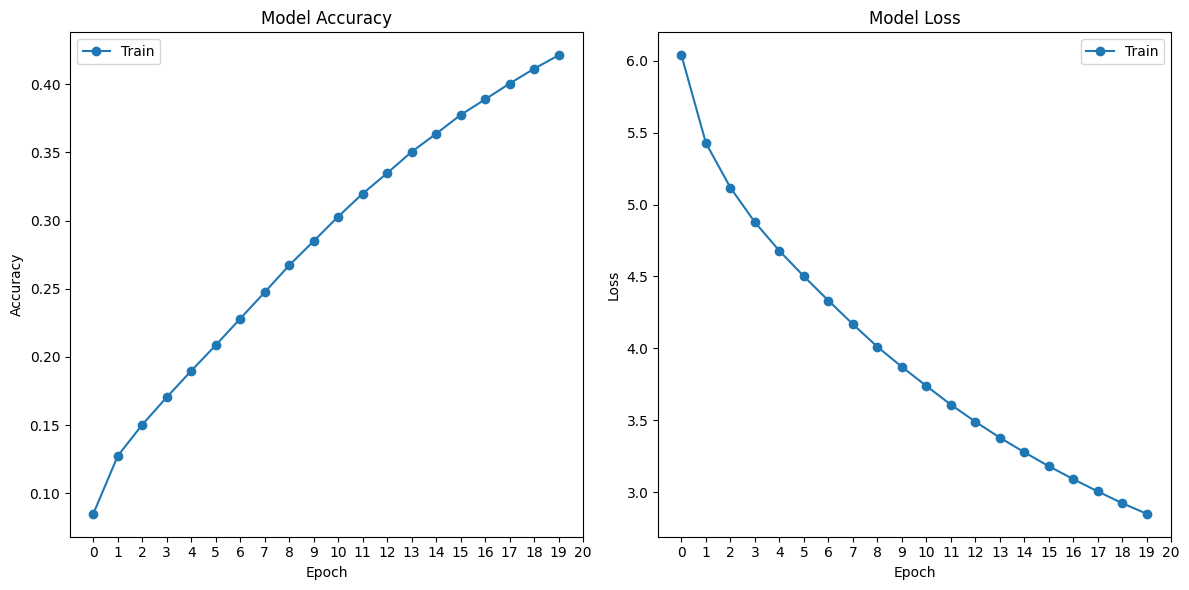

In [15]:
import matplotlib.pyplot as plt

# Plot training accuracy values
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, len(history.history['accuracy'])+1))
plt.legend(['Train'], loc='upper left')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, len(history.history['loss'])+1))
plt.legend(['Train'], loc='upper right')

plt.tight_layout()
plt.show()
